# Double Quantum dot (DQD):

In this notebook we go over the code developed to simulate a 2$\times$N array of QDs by using the capacitance model.
This is a completely classical model in which our array of QDs is represented as a network of capacitors consisting of:
* Gate capacitors $C_g$
* Mutual capacitors $C_m$
* Cross capacitors $C_c$

The energy of a particular electron configuration $N$ can then be calculated as:
<br/>
<br/>
<center>
$E = \frac{1}{2} \vec{Q} \cdot \bf{C}^{-1} \vec{Q}$
</center>
<br/>
Where $\vec{Q}$ is the charge on each quantum dot, defined as $q_i = V_{gi}C_{gi}-\sum_j C_{c_{ij}}V_{gj} -eN_i$
 and $C$ is the capacitance matrix, which for a DQD is given as:
 <br/>
 <br/>
<center>
 $\bf{C} = \begin{pmatrix}
            C_1 & -C_m\\
            -C_m & C_2
            \end{pmatrix}$
</center>
<br/>
For more information, see:

[ Wiel, W. G. Van Der. (2003). Electron transport through double quantum dots. ](https://arxiv.org/pdf/cond-mat/0205350.pdf)

## Importing required packages:

In [1]:
# Python packages
import matplotlib.pyplot as plt
import numpy as np
import time
# Custom python files written for project
import stability as stab
import NN as nn
import Data_processing as process

# pretrained neural network
model, r_x = nn.load_model('model')

## Simulating a DQD:

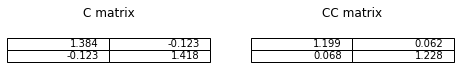

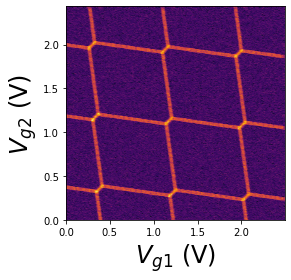

In [17]:
# Simulate DQD stability diagram
# N.B. since there is only capacitance perpendicular to nanowire, ratio  is set to one
Vg1, Vg2, I, C, CC, dots = stab.stab_dqd(300)

# Plot table of C and CC matrix used
stab.plot_c(C, CC)

# Plot stability diagram
plt.figure()
stab.plot_stab(Vg1, Vg2, 'V', dots, z=I)

# Simulating a 2$\times$2 array of QDs:

Due to visualisation purposes, we are going to apply voltages at two dots at a time.
Also, to show that extra transitions do appear at specific gate voltages, we are going to apply higher gate voltages and thus recreate the stability diagram within the paper.

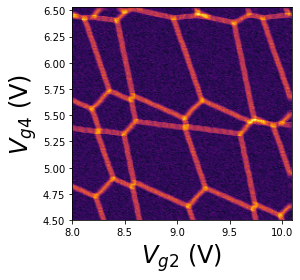

In [2]:
# Setting up values
N_QD, res, blur, freq = 4, 200, 5, 2
signal = np.random.uniform(50, 100, 1)
dots = [1, 3]

# Values of the capacitance used within the paper:
C = np.array([[ 1.61985818, -0.40839002, -0.06621002, -0.0363675 ],
              [-0.40839002,  1.85134262, -0.05580086, -0.30766702],
              [-0.06621002, -0.05580086,  1.68453668, -0.38063206],
              [-0.0363675 , -0.30766702, -0.38063206,  1.87725365]])

CC = np.array([[1.02248092, 0.04857599, 0.02723455, 0.01059919],
               [0.05873536, 0.95193755, 0.0118957 , 0.05691611],
               [0.04809363, 0.03219296, 1.05491902, 0.04668813],
               [0.04828182, 0.02871698, 0.09730076, 0.97828752]])


Cg = np.array([CC[0,0], CC[1,1], CC[2,2], CC[3,3]])


'''
To obtain a random set of capacitor values, uncoment the following piece of code,
although the offset voltages and electron numbers might need tweeking accordingly
'''

# c = sorted(np.random.uniform(1, 0.01, 3))
# C, Cg, CC, CM = stab.random_c(c[2], c[0], c[1], N_QD, sorted(np.random.uniform(0,1,3)))

'''
Since we are applying higer voltages, we are going to add electrons to the dots being probed accordingly 
this is to reduce the amount of RAM required to run the algorithem.
This can be tuned by accordingly by chechink the electron configuration within st
'''

N = stab.n_states(N_QD, freq + 3, freq + 2)
N[:, dots[0]], N[:, dots[1]] = N[:, dots[0]] + 7, N[:, dots[1]] + 5

V = stab.voltage(N_QD, freq, res, N, Cg, dots)
V[dots[0]], V[dots[1]] = V[dots[0]] + 8, V[dots[1]] + 4.5  # Offset voltages

st = stab.energy_tensor(N, V, C, CC)
intensity = stab.transition(st, res, signal, blur)
x, y, I = stab.matrix_to_array(intensity)

Vg2, Vg4 = x / Cg[dots[0]] / res * freq + 8, y / Cg[dots[1]] / res * freq + 4.5 # Add offset voltages

# Plot stability diagram
stab.plot_stab(Vg2, Vg4, 'V', dots, z=I)

# Automatically tuning a 2D projection:

### Carrying the whole process in one step:

Here we show the hole process of extracting the partial rotation transformation matrix $g$ while sweeping two random gates at a time. We also measure the time taken to extract $g$ once the theoretical data of the stability diagram has been generated (generally most computationally intense part of the process).

Elapsed time to extract g: 0.12345552444458008 s


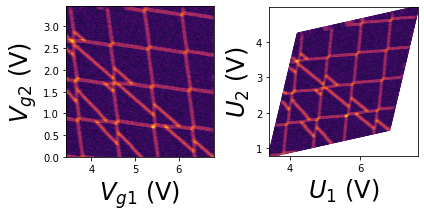

In [4]:
# Create random 2x2 dot stability diagram
Vx, Vy, I, C, CC, dots = stab.stab_fqd(200)

# From such diagram calculate the required partial rotation g
t = time.time()
x, y, z, x_h, y_h, fit = process.threshold_theoretical(Vx, Vy, I)
_, _, freq = process.line_fit(x, y, z)
grad = nn.predict_exp(model, freq, r_x)
g = stab.alpha_matrix(grad)
# Time taken to extract the partial rotation matrix g
elapsed = time.time()-t


# Partially rotated data
rotated = np.matmul(g, np.vstack([Vx, Vy]))

# Print final output
print('Elapsed time to extract g:', elapsed,'s')
# Plot results
plt.subplot(1,2,1)
stab.plot_stab(Vx, Vy, 'V', dots, z=I)
plt.subplot(1,2,2)
stab.plot_stab(rotated[0], rotated[1], 'U', dots, z=I)
plt.tight_layout()

We are now going to go through the various intermediary steps as an educative process. 

## (1) 2D projection of a 2$\times$2 array

We are going to theoretically simulate a 2$\times$2 array of QDs, in which two random gates are being swept at a time with a random voltage offset. For certain voltage combinations, there will be extra transition lines that will appear from the QDs that are not being probed, although this is not guaranteed. 

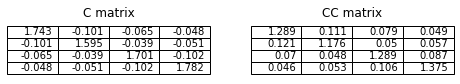

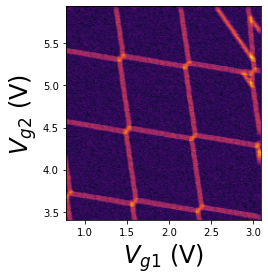

In [2]:
# Create random 2x2 dot stability diagram
Vx, Vy, I, C, CC, dots = stab.stab_fqd(200)

# Plot table of C and CC matrix used
stab.plot_c(C, CC)

# Plot 2x2 stability diagram
plt.figure()
stab.plot_stab(Vx, Vy, 'V', dots, z=I)

## (2) Thresholding the data:

We create a histogram of the data in *I* and fit two Guassian distributions, the one with the larger amplitude will represent the background noise, while the smaller one will be our signal. Once thresholded we take a weighted average to thin the data set. This helps to reduce any ailacing effects on the Hough transform.

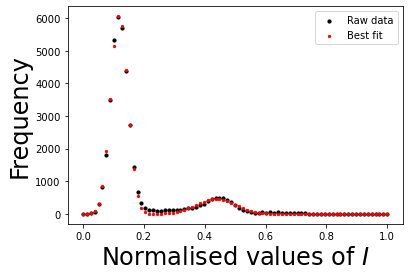

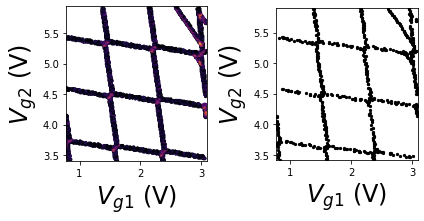

In [3]:
# Threshold data by fitting two Gaussian distributions to the histogram of I
x, y, z, x_h, y_h, fit = process.threshold_theoretical(Vx, Vy, I)
# Thin data by taking weighted average of data points
xs, ys, _ = process.averaging_xy(x, y, z, int((len(x)) ** 0.5 * 10), int((len(x)) ** 0.2))

# Plot histogram of I
plt.scatter(x_h, y_h, c='k', s=10)
plt.scatter(x_h, process.multi_gaussian(x_h, *fit), c='r', s=5)
plt.xlabel('Normalised values of $I$', fontsize=24)
plt.ylabel('Frequency', fontsize=24)
plt.legend(('Raw data', 'Best fit'))
plt.show()

# Plot threshold data
plt.figure()
plt.subplot(121)
stab.plot_stab(x, y, 'V', dots, z=z)

# Plot thinned data after weighted average
plt.subplot(122)
stab.plot_stab(xs, ys, 'V', dots)

plt.tight_layout()

## (3) Taking Hough transform of the data:

Now that we have our thinned datapoints, each coordinate in $x$ and $y$ is passed transformed into Hough space by the following operation:
<br/>
<br/>
<center>
$\rho = x \cdot cos(\theta) + y \cdot sin(\theta)$
</center>
<br/>
Where $\theta$ is an array of the angles that we consider, in this case we go from $-\frac{\pi}{2}$ to $\frac{\pi}{2}$ with 1000 data points.

Text(0, 0.5, '$\\rho$')

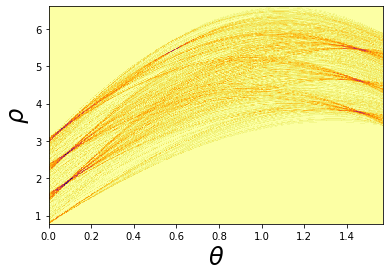

In [4]:
# Setting up Hough transform
data = np.transpose(np.vstack([xs, ys]))
theta = np.reshape(np.linspace(0, np.pi / 2, 500 + 1), (1, 500 + 1)) # Angles considered
a = process.hough_transform(data, theta)
t = np.tile(theta, len(a) // len(theta[0]))

# Plot Hough transform
plt.hist2d(t[0], a, bins=len(theta[0]), cmap='inferno_r')
plt.xlabel(r'$\theta$', fontsize=24)
plt.ylabel(r'$\rho$', fontsize=24)

## (4) $\theta$ histogram

We now threshold the values in $\theta$ to obtain the most likely candidates for our gradients $m$, since:
<br/>
<br/>
<center>
$m = - \frac{1}{tan(\theta)}$
</center>
<br/>

(-0.00021234902019746403, 0.023358392221721043)

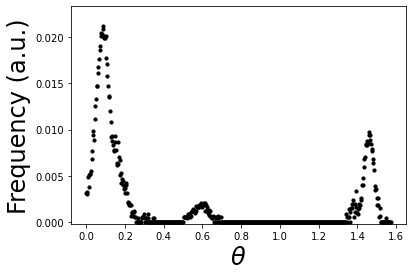

In [5]:
freq = process.hough_theta(data, theta)

# Plot theta histogram 
plt.scatter(theta, freq, c='k', s=10)
plt.xlabel(r'$\theta$', fontsize=24)
plt.ylabel('Frequency (a.u.)', fontsize=24)
plt.ylim(-np.max(freq)*0.01, np.max(freq)*1.1)

## (5) Predicting gradients with NN:

We now import our pretrained neural network, which takes the frequency values of our $\theta$ histogram as its input and predicts the two dot to reservour gradients of the dots being probed ($i$, $j$), which will be $r_i^{ij}$,  and $r_j^{ij}$.

In [6]:
grad = nn.predict_exp(model, freq, r_x)
print(grad)

[-5.576055  -0.2381209]


## (6) Creating transformation matrix g:

Since we have only probed two gate voltages and we have extracted only two gradients, we can only do a partial rotation to make $V_{gi}$ and $V_{gj}$ independent of eachother within this 2D projection.
This partial rotation matrix, which here we denote as $\bf{g}_{ij}$ will be given by:
<br/>
<br/>
<center>
$ \large{\bf{g_{ij}} = \frac{1}{-sin(\phi^{ij}_i)}
    \begin{pmatrix}
    -sin(\phi^{ij}_i) & cos(\phi^{ij}_j)\\
    -sin(\phi^{ij}_j) & cos(\phi^{ij}_j)
    \end{pmatrix}}$
</center>
Where $\phi^{ij}_i = tan^{-1}(r_i^{ij})$ and $\phi^{ij}_j = tan^{-1}(r_j^{ij})$

In [7]:
g = stab.alpha_matrix(grad)
print(g)

[[1.         0.17933834]
 [0.23533977 0.98832053]]


## (7) Virtual voltage space:

Now that we have $\bf{g}_{ij}$, we can do a partial rotation in terms of $V_{gi}$ and $V_{gj}$ and then resimulate what our 2D projection stability diagram looks like, as:
<br/>
<br/>
<center>
$\vec{V}_g = \bf{g}_{ij}^{-1} \cdot \vec{U}$
</center>

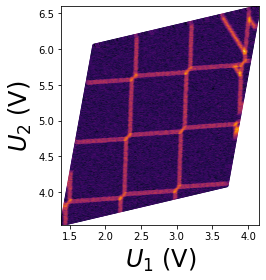

In [8]:
rotated = np.matmul(g, np.vstack([Vx, Vy]))

# Plot rotated data
stab.plot_stab(rotated[0], rotated[1], 'U', dots, z=I)

# Extracting $G$:

This process has to be then repeated another five times in order to reconstruct the $\bf{G}$ matrix to obtain the overall virtual voltages, resulting in the following six projections:
<table style="width:400px", class="center">
<tr>
<th> 1) $V_{g1}$ vs $V_{g2} \rightarrow r^{12}_1$ and $r^{12}_2$ </th>
<th> 4) $V_{g2}$ vs $V_{g3} \rightarrow r^{23}_2$ and $r^{23}_3$ </th>
</tr>
</table>

<table style="width:400px", class="center">
<tr>
<th> 2) $V_{g1}$ vs $V_{g3} \rightarrow r^{13}_1$ and $r^{13}_3$ </th>
<th> 5) $V_{g2}$ vs $V_{g4} \rightarrow r^{24}_2$ and $r^{24}_4$ </th>
</tr>
</table>

<table style="width:400px", class="center">
<tr>
<th> 3) $V_{g1}$ vs $V_{g4} \rightarrow r^{14}_1$ and $r^{14}_4$ </th>
<th> 6) $V_{g3}$ vs $V_{g4} \rightarrow r^{34}_3$ and $r^{34}_4$ </th>
</tr>
</table>


Once all the gradients are extracted, $\bf{G}$ can be determined as:
<br/>
<br/>
<center>
$ \large{
\bf{G} = \begin{pmatrix}
1 & -\frac{1}{tan(\phi^{12}_1)}\cdot G_{11} & -\frac{1}{tan(\phi^{13}_1)}\cdot G_{11} & -\frac{1}{tan(\phi^{14}_1)}\cdot G_{11}\\[2ex]
\frac{sin(\phi^{12}_2)}{sin(\phi^{12}_1)}\cdot G_{11} & -\frac{cos(\phi^{12}_2)}{sin(\phi^{12}_1)}\cdot G_{11} & -\frac{1}{tan(\phi^{23}_2)} \cdot G_{22} & -\frac{1}{tan(\phi^{24}_2)} \cdot G_{22}\\[2ex]
\frac{sin(\phi^{13}_3)}{sin(\phi^{13}_1)}\cdot G_{11} & \frac{sin(\phi^{23}_3)}{sin(\phi^{23}_2)}\cdot G_{22} & -\frac{cos(\phi^{23}_3)}{sin(\phi^{23}_2)}\cdot G_{22} & -\frac{1}{tan(\phi^{34}_3)} \cdot G_{33}\\[2ex]
\frac{sin(\phi^{14}_4)}{sin(\phi^{14}_1)}\cdot G_{11} &  \frac{sin(\phi^{24}_4)}{sin(\phi^{24}_2)}\cdot G_{22} & \frac{sin(\phi^{34}_4)}{sin(\phi^{34}_3)}\cdot G_{33} & -\frac{cos(\phi^{34}_4)}{sin(\phi^{34}_3)}\cdot G_{33}
\end{pmatrix}
}$
</center>
<br/>

Here we have carried this out for a given data set and applied voltages onto all four virtual voltages simultaniously. Depending on the amount of RAM available in the system, the user may have to reduce both values of `res` and `freq`.

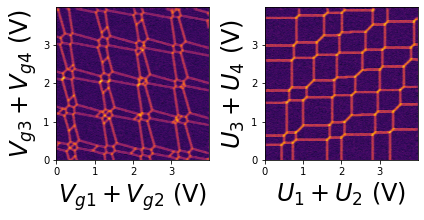

In [39]:
N_QD, res, blur, freq = 4, 300, 5, 4
signal = np.random.uniform(50, 100, 1)

# Values of the capacitance used within the paper:
C = np.array([[ 1.61985818, -0.40839002, -0.06621002, -0.0363675 ],
              [-0.40839002,  1.85134262, -0.05580086, -0.30766702],
              [-0.06621002, -0.05580086,  1.68453668, -0.38063206],
              [-0.0363675 , -0.30766702, -0.38063206,  1.87725365]])

CC = np.array([[1.02248092, 0.04857599, 0.02723455, 0.01059919],
               [0.05873536, 0.95193755, 0.0118957 , 0.05691611],
               [0.04809363, 0.03219296, 1.05491902, 0.04668813],
               [0.04828182, 0.02871698, 0.09730076, 0.97828752]])

Cg = np.array([CC[0,0], CC[1,1], CC[2,2], CC[3,3]])

G = np.array([[1.        , 0.26430576, 0.09911402, 0.09194791],
              [0.33903858, 0.97719516, 0.12779685, 0.24700595],
              [0.12109078, 0.1076932 , 0.97961451, 0.24023306],
              [0.1515827 , 0.21822771, 0.33301288, 0.95208137]])

# Symulate stability diagram while sweeping all four gate voltages simultaniously 
N = stab.n_states(N_QD, freq + 3, freq + 2)
V = stab.voltage(N_QD, freq, res, N, np.ones(4), [0, 2])
V[1], V[3] = V[0], V[2]
st = stab.energy_tensor(N, V, C, CC)
intensity = stab.transition(st, res, signal, blur)
Vx, Vy, Vz = stab.matrix_to_array(intensity)
Vx, Vy = Vx / res * freq, Vy / res * freq

# Symulate corresponding stability diagram in virtual voltage space
U = stab.virtual_volt(V, G)
st_v = stab.energy_tensor(N, U, C, CC)
int_v = stab.transition(st_v, res, signal, blur)
Ux, Uy, Uz = stab.matrix_to_array(int_v)
Ux, Uy = Ux / res * freq, Uy / res * freq

# Plot respective stability diagrams
plt.subplot(1,2,1)
stab.plot_stab(Vx, Vy, 'Vall', [0, 2], z=Vz)
plt.xlabel(r'$V_{g1} + V_{g2}$ (V)', fontsize=24)
plt.ylabel(r'$V_{g3} + V_{g4}$ (V)', fontsize=24)

plt.subplot(1,2,2)
stab.plot_stab(Ux, Uy, 'Uall', [0, 2], z=Uz)
plt.xlabel(r'$U_1 + U_2$ (V)', fontsize=24)
plt.ylabel(r'$U_3 + U_4$ (V)', fontsize=24)
plt.tight_layout()

# Experimental data

In [2]:
# Import required packages and function to import experimental data
import pandas as pd
import os
import glob
import multiprocessing as mp
import dask.dataframe
def data_column(data, i):
    return data[:, i]
def import_data(folder):
    cwd = os.getcwd()
    directory_path = os.path.abspath(os.path.join(cwd, 'Data', folder))
    os.chdir(directory_path)
    for file in glob.glob("*.dat"):
        data = np.array(dask.dataframe.read_csv(file, sep="\t", skiprows=[0, 2], false_values='#', dtype={'# "Channel 3 voltage"': 'float64'}))
        pool = mp.Pool(mp.cpu_count())
        Vg2 = pool.apply_async(data_column, [data, 0]).get()
        Vg1 = pool.apply_async(data_column, [data, 1]).get()
        I = pool.apply_async(data_column, [data, 2]).get()
        Q = pool.apply_async(data_column, [data, 3]).get()
        Magnitude = pool.apply_async(data_column, [data, 4]).get()
        Phase = pool.apply_async(data_column, [data, 5]).get()
        pool.close()
    os.chdir(cwd)
    return Vg1, Vg2, I, Q, Magnitude, Phase

In [3]:
# import data
Vg1, Vg2, I, Q, Magnitude, Phase = import_data('022')

#### Plot raw data

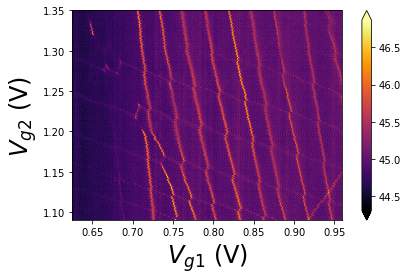

In [5]:
stab.plot_stab(Vg1, Vg2, 'V', [0, 1], z=Phase)
cbar = plt.colorbar(extend='both')
plt.xlim(0.625,0.96)
plt.ylim(1.09, 1.35)
# plt.savefig('Raw_data', dpi=600, format='png')

#### Flatten data

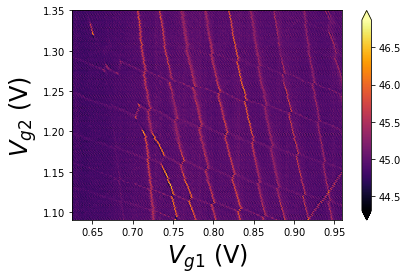

In [4]:
# Flattens background and adds low pass filter
p = process.remove_background(Vg1, Vg2, Phase)

stab.plot_stab(Vg1, Vg2, 'V', [0, 1], z=p)
cbar = plt.colorbar(extend='both')
plt.xlim(0.625,0.96)
plt.ylim(1.09, 1.35)
# plt.savefig('Flattened_data', dpi=600, format='png')

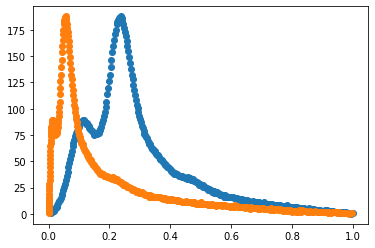

In [23]:
#i = process.remove_background(Vg1, Vg2, I)
x, y = process.hist_data(process.normalise(I))
y = y**0.5
x = 1 - x
plt.scatter(x,y)
x = x**2
plt.scatter(x,y)

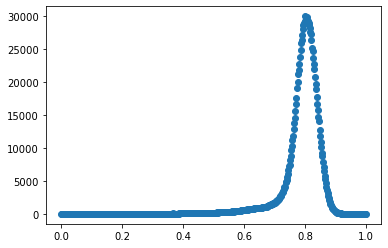

In [8]:
x, y = process.hist_data(process.normalise(i))
plt.scatter(x,y)

#### Threshold data

(1.09, 1.35)

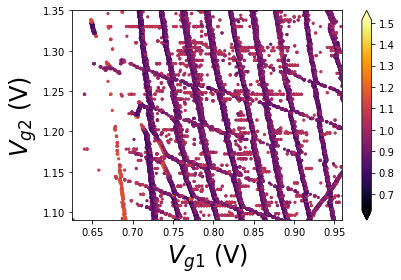

In [5]:
# Threshold data
x, y, z = process.threshold_experimental(Vg1, Vg2, I, Q)
stab.plot_stab(x, y, 'V', [0, 1], z=z)
cbar = plt.colorbar(extend='both')
plt.xlim(0.625,0.96)
plt.ylim(1.09, 1.35)
#plt.savefig('Threshold_data', dpi=600, format='png')

#### Thin data-set

(1.09, 1.35)

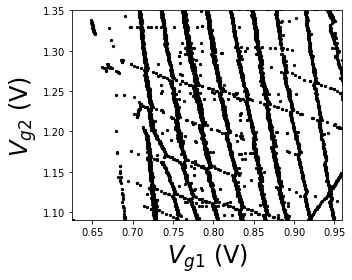

In [6]:
xs, ys, _ = process.averaging_xy(x, y, z, np.int((len(x)) ** 0.5 * 10), np.int(10))
stab.plot_stab(xs, ys, 'V', [0, 1])
plt.xlim(0.625,0.96)
plt.ylim(1.09, 1.35)
# plt.savefig('Thinned_data', dpi=600, format='png')

#### $\theta$ histogram

[-3.7128656  -0.48706943]


Text(0, 0.5, 'Intensity (a.u.)')

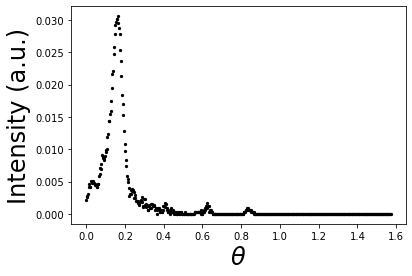

In [7]:
# Extract g
xs, ys, freq = process.line_fit(x, y, z)
theta = np.reshape(np.linspace(0, np.pi / 2, 500 + 1), (1, 500 + 1)) # Angles considered
grad = nn.predict_exp(model, freq, r_x)
g = stab.alpha_matrix(grad)
rotated = np.matmul(g, np.vstack([Vg1, Vg2]))
print(grad)
plt.scatter(theta, freq, s=5, c='k')
plt.xlabel(r'$\theta$', fontsize=24)
plt.ylabel('Intensity (a.u.)', fontsize=24)

#### Rotated data into virtual voltage space

(1.4, 1.6)

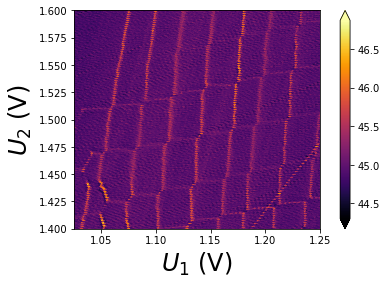

In [9]:
# Plot rotated dataset in Virtual voltage space
p = process.remove_background(Vg1, Vg2, Phase)
stab.plot_stab(rotated[0], rotated[1], 'U', [0, 1], z=p)
cbar = plt.colorbar(extend='both')
plt.xlim(1.025, 1.25)
plt.ylim(1.4, 1.6)
#plt.savefig('Rotated_data', dpi=600, format='png')